# Init

In [61]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [10]:
with open('pickle/tfidf_df.p', 'rb') as file:
    tfidf_df = pickle.load(file)
tfidf_df.head()

,acordo,afirma,afirmou,apesar,brasil,brasileira,brasileiro,campanha,centro,chegou,...,regiao,resultado,rousseff,seguranca,semana,situacao,trabalho,ultima,ultimos,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.113346,0.000000,0.0,0.0,0.0,6
1,0.000000,0.000000,0.000000,0.218331,0.000000,0.0,0.0,0.224543,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,3
2,0.106243,0.000000,0.198091,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.135876,0.0,0.0,0.0,6
3,0.000000,0.000000,0.403944,0.000000,0.262744,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.139283,0.0,0.113967,0.000000,0.0,0.0,0.0,5
4,0.234460,0.100607,0.174861,0.000000,0.000000,0.0,0.0,0.462245,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,5


In [11]:
X = tfidf_df.drop(columns=['target'])
y = tfidf_df['target']

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Classifier

In [35]:
#model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
#model.fit(x_train, y_train)

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=500, random_state=42)

In [42]:
#model = RandomForestClassifier(n_estimators=100, random_state=42)
#model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
#model = SVC(kernel='linear', probability=True, random_state=42)
#model.fit(x_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [56]:
#model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
#model.fit(x_train, y_train)

LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

In [62]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(x_train, y_train)

model = grid_search.best_estimator_

In [63]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test) 

# Analysis

In [64]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.12      0.15       159
           1       0.36      0.58      0.44       337
           2       0.18      0.12      0.14       104
           3       0.26      0.28      0.27       237
           4       0.25      0.38      0.30       213
           5       0.30      0.39      0.34       302
           6       0.25      0.06      0.10       145
           7       0.34      0.16      0.22       170
           8       0.29      0.07      0.11       120
           9       0.36      0.32      0.34       219

    accuracy                           0.30      2006
   macro avg       0.28      0.25      0.24      2006
weighted avg       0.29      0.30      0.28      2006



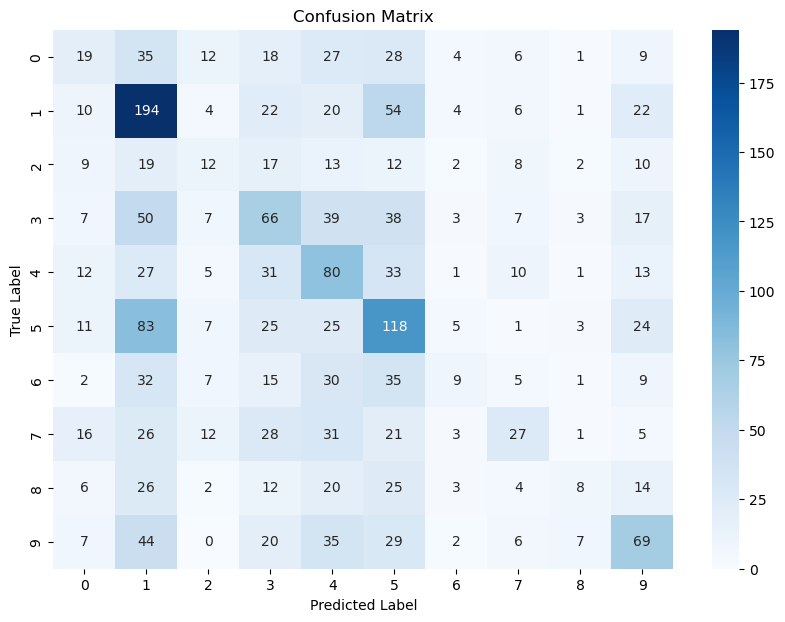

In [65]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

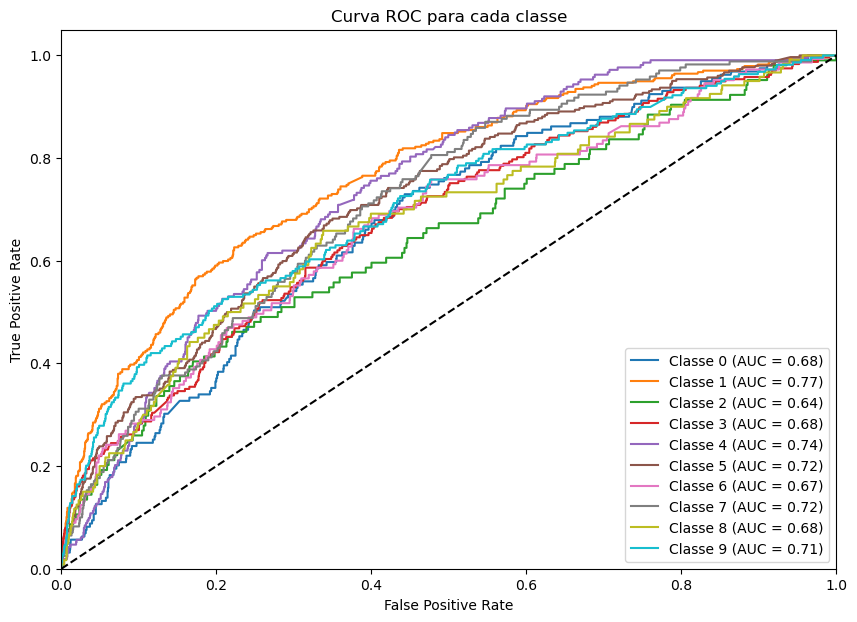

In [66]:
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
roc_auc = dict()
fpr = dict()
tpr = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotando a Curva ROC
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Classe {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para cada classe')
plt.legend(loc='lower right')
plt.show()